## 4B. Training Refinement Network

In this stage we train the Refinement Network, which is a 1D MultiResUNet network.

The training in performed using 10 fold cross validation, and thus 10 models are obtained. 

Training the refinement network actually starts from loading the corresponding approximate network of that fold. After that approximate network has been loaded, the prediction by that network is computed and the refinement network is trained on that prediction to refine it further.

The models are stored in a *models* directory and also the training history gets stored in a *History* directory.

The file system becomes as follows

 .<br /> 
├── raw_data<br /> 
├── data<br /> 
├── History<br /> 
├── models<br /> 
│   ├── MultiResUNet1D_model2_fold0.h5<br />
│   ├── MultiResUNet1D_model2_fold1.h5<br />
│   ├── ...<br /> 
│   ├── MultiResUNet1D_model2_fold9.h5<br />
│   ├── UNetDS64_model1_fold0.h5<br /> 
│   ├── UNetDS64_model1_fold1.h5<br /> 
│   ├── ...<br /> 
│   └── UNetDS64_model1_fold9.h5<br /> 
└ ...


----------------
Training Fold 1
----------------


Preparing Data for DS: 100%|██████████| 110/110 [00:00<00:00, 110376.42it/s]


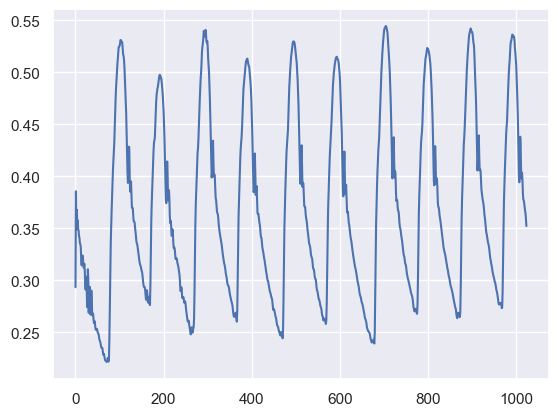

Preparing Data for DS: 100%|██████████| 10/10 [00:00<00:00, 10053.46it/s]


Epoch 1/100
1/1 [==============================] - 37s 37s/step - loss: 2.4562 - mean_absolute_error: 1.1526 - val_loss: 0.0318 - val_mean_absolute_error: 0.1493

Epoch 00001: val_loss improved from inf to 0.03176, saving model to models\MultiResUNet1D_model2_fold0.h5


c:\ProgramData\Anaconda3\envs\tf\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
1/1 [==============================] - 1s 843ms/step - loss: 2.5930 - mean_absolute_error: 1.0035 - val_loss: 0.1453 - val_mean_absolute_error: 0.3599

Epoch 00002: val_loss did not improve from 0.03176
Epoch 3/100
1/1 [==============================] - 1s 641ms/step - loss: 0.9258 - mean_absolute_error: 0.7212 - val_loss: 0.1277 - val_mean_absolute_error: 0.3194

Epoch 00003: val_loss did not improve from 0.03176
Epoch 4/100
1/1 [==============================] - 1s 659ms/step - loss: 0.5388 - mean_absolute_error: 0.5265 - val_loss: 0.0931 - val_mean_absolute_error: 0.2640

Epoch 00004: val_loss did not improve from 0.03176
Epoch 5/100
1/1 [==============================] - 1s 690ms/step - loss: 0.3730 - mean_absolute_error: 0.4574 - val_loss: 0.0761 - val_mean_absolute_error: 0.2420

Epoch 00005: val_loss did not improve from 0.03176
Epoch 6/100
1/1 [==============================] - 1s 658ms/step - loss: 0.2658 - mean_absolute_error: 0.4131 - val_loss: 0.0886 - val_mean_

In [10]:
from helper_functions import *
from models import *
import time
from tqdm import tqdm
import pickle
import os
from tensorflow.keras.optimizers import Adam

"""
    Trains the refinement network in 10 fold cross validation manner
"""

model_dict = {}                                             # all the different models
model_dict['UNet'] = UNet
model_dict['UNetLite'] = UNetLite
model_dict['UNetWide40'] = UNetWide40
model_dict['UNetWide48'] = UNetWide48
model_dict['UNetDS64'] = UNetDS64
model_dict['UNetWide64'] = UNetWide64
model_dict['MultiResUNet1D'] = MultiResUNet1D
model_dict['MultiResUNetDS'] = MultiResUNetDS


mdlName1 = 'UNetDS64'                                       # approximation network
mdlName2 = 'MultiResUNet1D'                                 # refinement network

length = 1024                                               # length of the signal

                                                                # 10 fold cross validation
for foldname in range(1):

    print('----------------')
    print('Training Fold {}'.format(foldname+1))
    print('----------------')
                                                                                        # loading training data
    dt = pickle.load(open(os.path.join('data','train{}.p'.format(foldname)),'rb'))
    X_train = dt['X_train']
    Y_train = dt['Y_train']
                                                                                        # loading validation data
    dt = pickle.load(open(os.path.join('data','val{}.p'.format(foldname)),'rb'))
    X_val = dt['X_val']
    Y_val = dt['Y_val']

                                                                                        # loading metadata
    dt = pickle.load(open(os.path.join('data','meta{}.p'.format(foldname)),'rb'))
    max_ppg = dt['max_ppg']
    min_ppg = dt['min_ppg']
    max_abp = dt['max_abp']
    min_abp = dt['min_abp']


    Y_train = prepareLabel(Y_train)                                         # prepare labels for training deep supervision
    
    Y_val = prepareLabel(Y_val)                                             # prepare labels for training deep supervision


    mdl1 = model_dict[mdlName1](length)                 # load approximation network
    mdl1.load_weights(os.path.join('models','{}_model1_fold{}.h5'.format(mdlName1,foldname)))   # load weights

    X_train = prepareDataDS(mdl1, X_train)          # prepare training data for 2nd stage, considering deep supervision
    X_val = prepareDataDS(mdl1, X_val)              # prepare validation data for 2nd stage, considering deep supervision

    mdl1 = None                                 # garbage collection


    mdl2 = model_dict[mdlName2](length)            # create refinement network

                                                                # loss = mse
    mdl2.compile(loss='mean_squared_error',optimizer='adam',metrics=['mean_absolute_error'])

    checkpoint2_ = ModelCheckpoint(os.path.join('models','{}_model2_fold{}.h5'.format(mdlName2,foldname)), verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

                                                            # train refinement network for 100 epochs
    history2 = mdl2.fit(X_train,Y_train['out'],epochs=100,batch_size=192,validation_data=(X_val,Y_val['out']),callbacks=[checkpoint2_])

    pickle.dump(history2.history, open('History/{}_model2_fold{}.p'.format(mdlName2,foldname),'wb'))    # save training history

    time.sleep(10)                                         # pause execution for a while to free the gpu



In [8]:
from helper_functions import *
from models import UNetDS64, MultiResUNet1D
import os
from predict_test import predict_test_data

predict_test_data()

1/1 [==============================] - 2s 2s/step


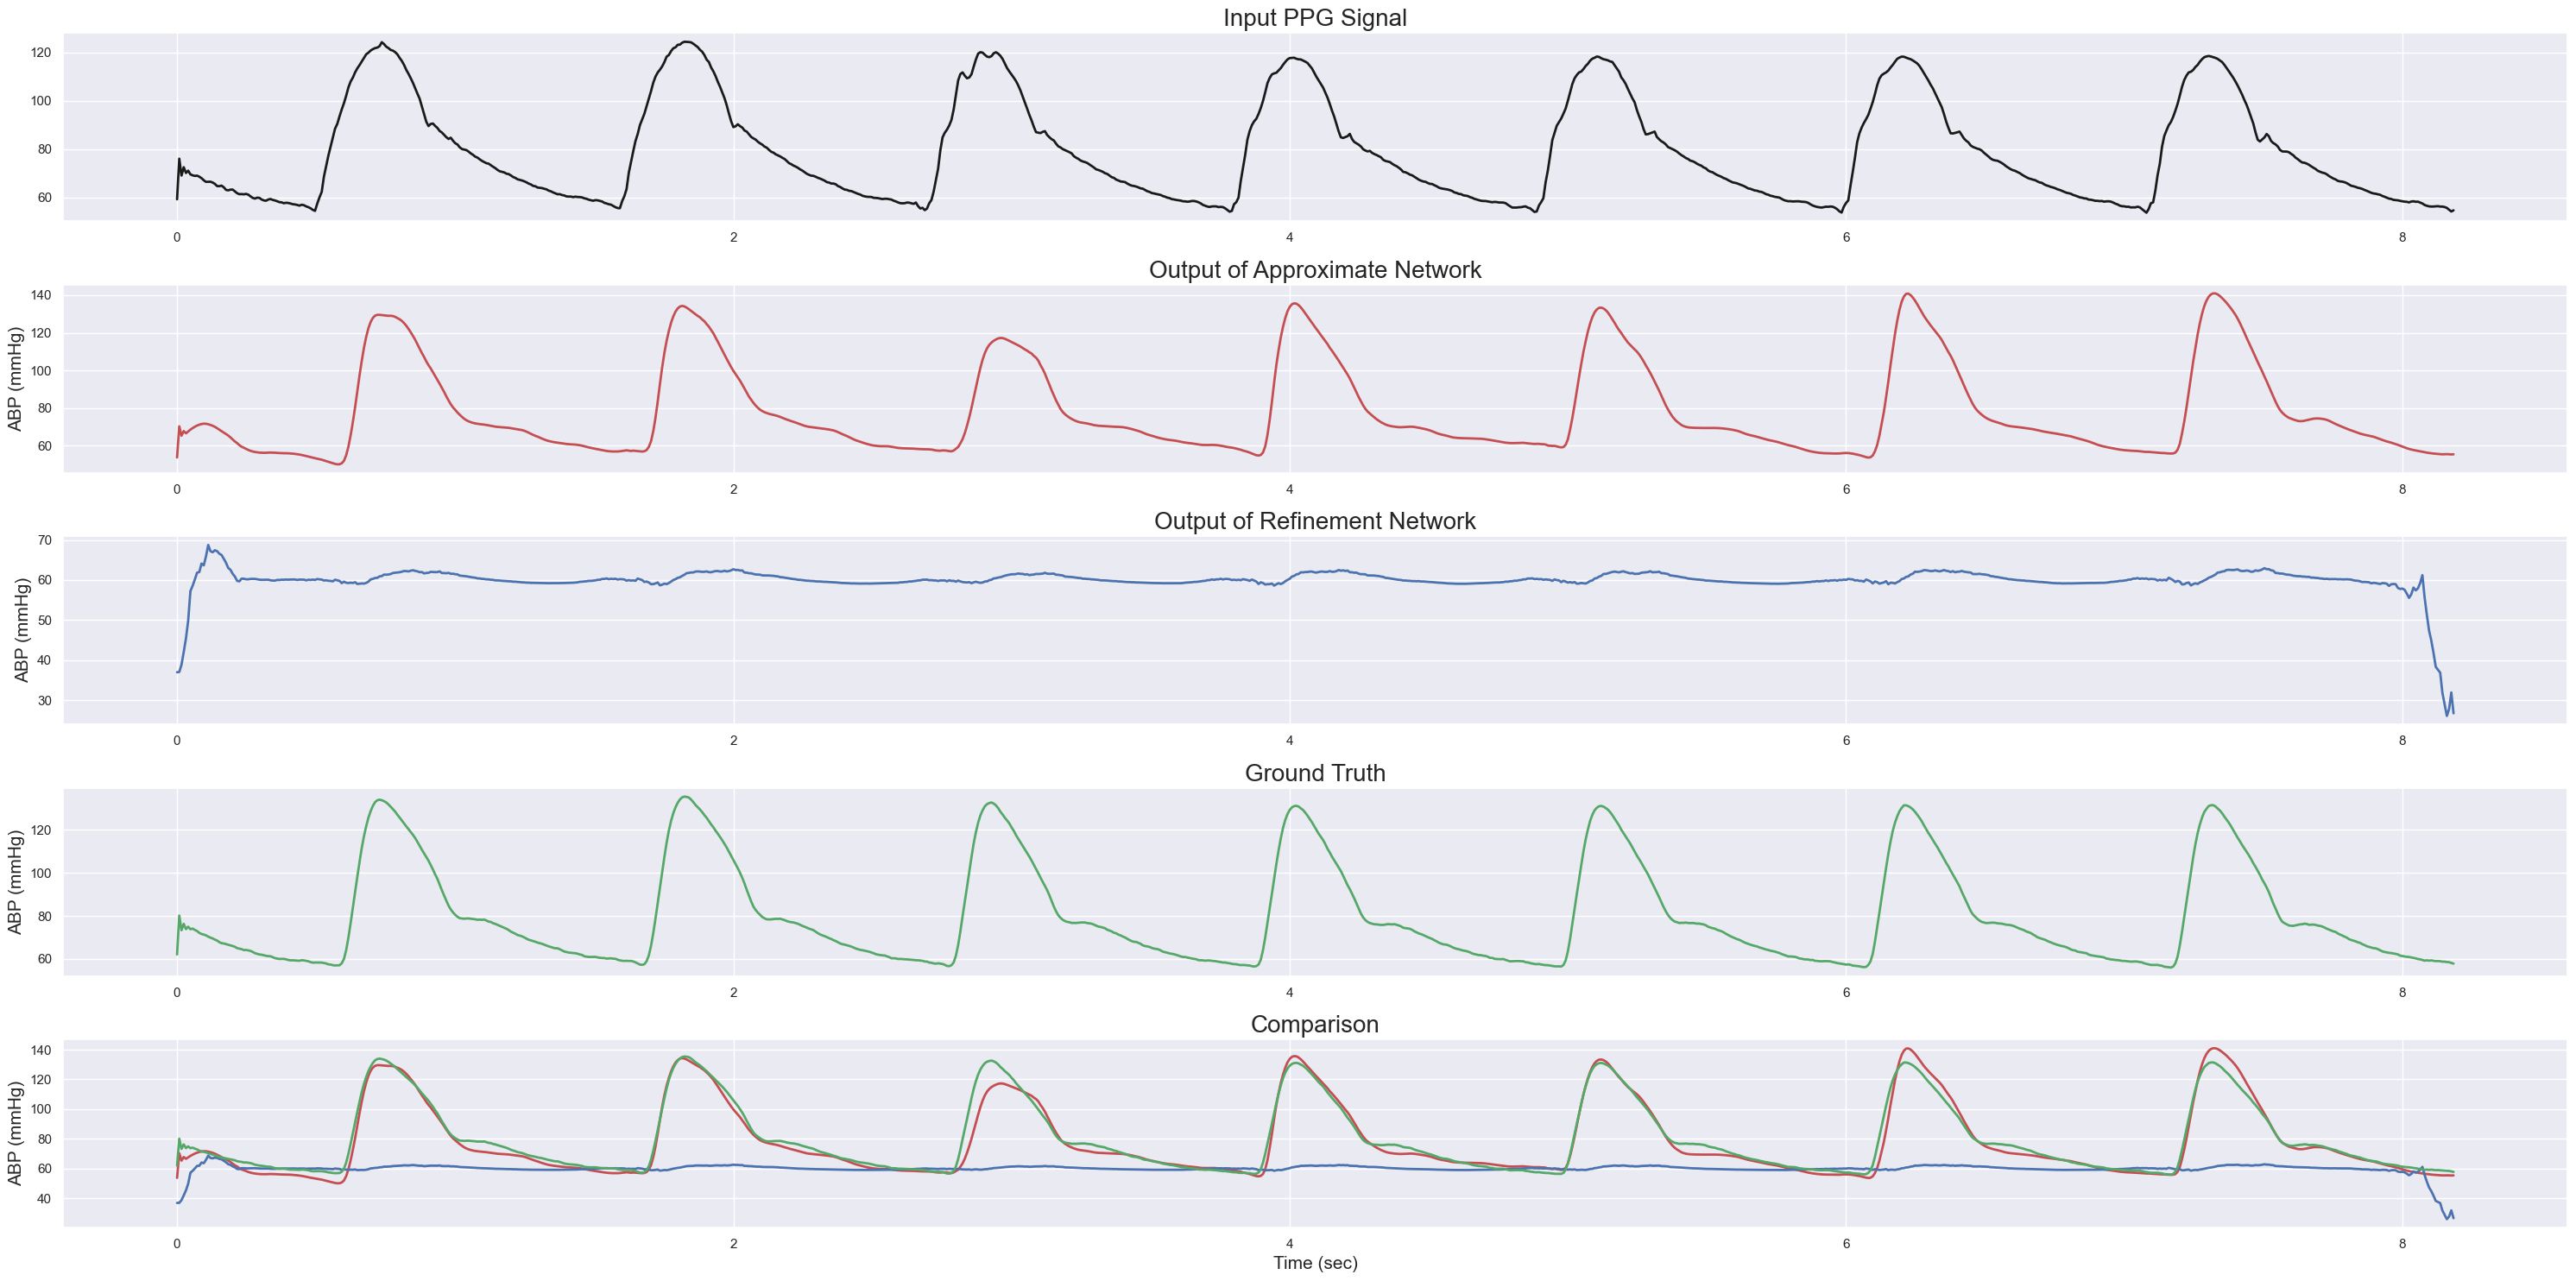

ValueError: invalid literal for int() with base 10: ''

In [9]:
#冻住前10层
from evaluate import predicting_ABP_waveform

predicting_ABP_waveform()

In [7]:
for layer in mdl1.layers:
    print(layer)
    # layer.trainable = False